Loading Conditions

1. Wing (Horizontal)
- a. Distributed Load (Lift)
- b. Weight of entire plane in middle of beam (overestimate)

2. Wing (Vertical)
- a. Pinned supports at motor locations
- b. Weight of entire plane in middle of beam (overestimate)

3. Wing to Tail (1.4m)
- a. Cantilever beam with weight of tail at end + pitching moment (1Nm for now, make it variable)

4. Motor to Motor 
- a. Pinned at motor locations
- b. Weight of plane

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import pandas as pd
import scipy.integrate as integrate

$$Lift = C_l \frac{1}{2}\rho v^2 A $$

In [54]:
rho = 1.225 # kg/m^3
v = 18 # m/s

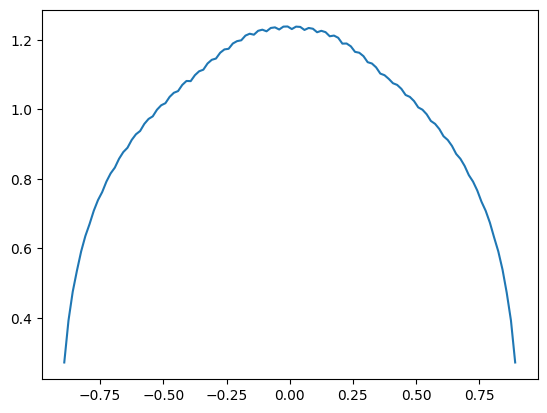

In [55]:
df = pd.read_csv('Book1.csv')
df['area'] = df['del_y']*df['Chord']
df['lift'] = df['area']*df['cl']*0.5*rho*v**2
plt.plot(df['y_span'],df['lift'])

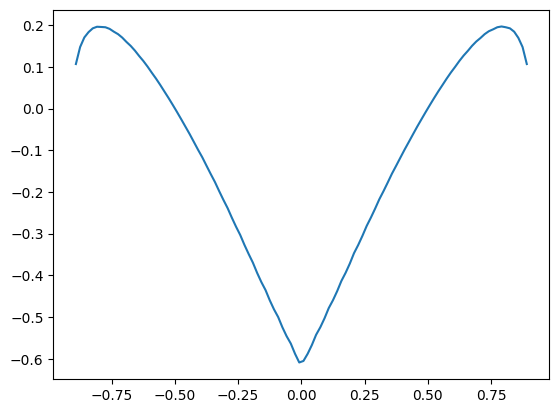

In [56]:
wing = pd.DataFrame()
wing['y_span'] = df['y_span']
wing['lift'] = df['lift']
pin_a = -0.5
pin_b = 0.5
moment1a = []

for index, row in wing.iterrows():
    if row['y_span'] < pin_a: # to left of pin a
        moment1a.append(-row['lift']*(row['y_span']-pin_a))
    elif row['y_span'] > pin_a and row['y_span'] < 0: # between pin a and center
        moment1a.append(-row['lift']*((row['y_span']-pin_a)))
    elif row['y_span'] > 0 and row['y_span'] < pin_b: # between center and pin b
        moment1a.append(-row['lift']*(pin_b-(row['y_span']))) 
    else: #to the right of pin b
           moment1a.append(-row['lift']*(pin_b-(row['y_span'])))


plt.plot(wing['y_span'],moment1a)


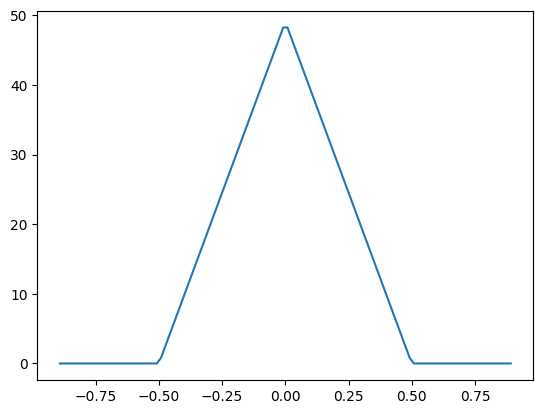

In [57]:
plane_mass = 10         #kg
W = plane_mass * 9.81   # weight in N acting in middle of wing spar
moment1b = []



for index, row in wing.iterrows():
    if row['y_span'] < pin_a: # to left of pin a
        moment1b.append(0)
    elif row['y_span'] > pin_a and row['y_span'] < 0: # between pin a and center
        moment1b.append(W * (row['y_span']-pin_a))
    elif row['y_span'] > 0 and row['y_span'] < pin_b: # between center and pin b
        moment1b.append(W * (pin_b-row['y_span'])) 
    else: #to the right of pin b
        moment1b.append(0)


plt.plot(wing['y_span'],moment1b)

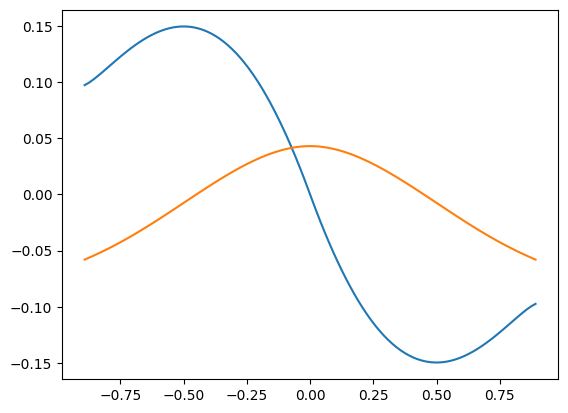

In [58]:
theta1a = integrate.cumulative_trapezoid(moment1a,wing['y_span'],initial = 0)
theta1a -= np.median(theta1a)
plt.plot(wing['y_span'], theta1a,label = 'theta1a')
displacement1a = integrate.cumulative_trapezoid(theta1a, wing['y_span'], initial=0)
displacement1a -= np.median(displacement1a)
plt.plot(wing['y_span'], displacement1a,label = 'displacement1a')

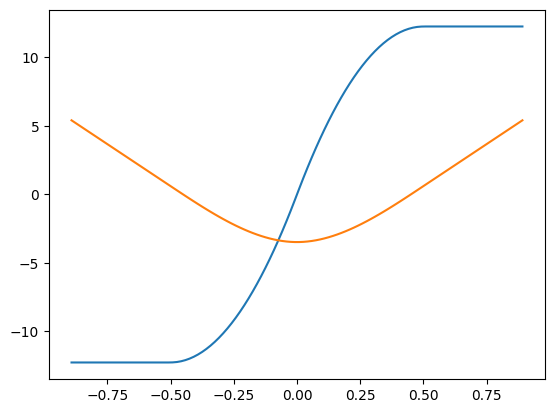

In [59]:
theta1b = integrate.cumulative_trapezoid(moment1b,wing['y_span'],initial = 0)
theta1b -= np.median(theta1b)
plt.plot(wing['y_span'], theta1b,label = 'theta1b')
displacement1b = integrate.cumulative_trapezoid(theta1b, wing['y_span'], initial=0)
displacement1b -= np.median(displacement1b)
plt.plot(wing['y_span'], displacement1b,label = 'displacement1b')

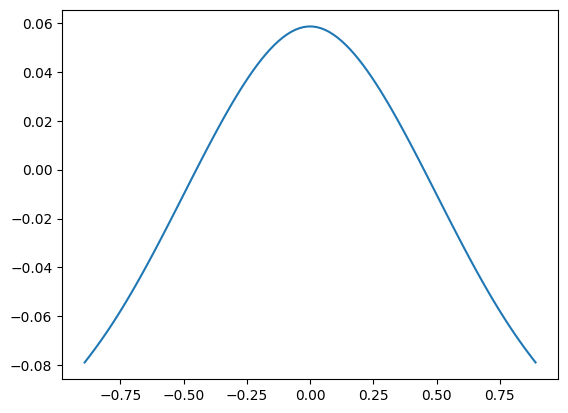

In [60]:
E = 227.527*10**9                           # GPA
ID = 0.01905                                # m
OD = 0.021082                               # m
I = ((np.pi)/64) * (OD**4-ID**4)            # m^4

displacement1a_scaled = []

for x in displacement1a:
    displacement1a_scaled.append((x/(E*I))*1000)      #displacement in mm

plt.plot(wing['y_span'], displacement1a_scaled)


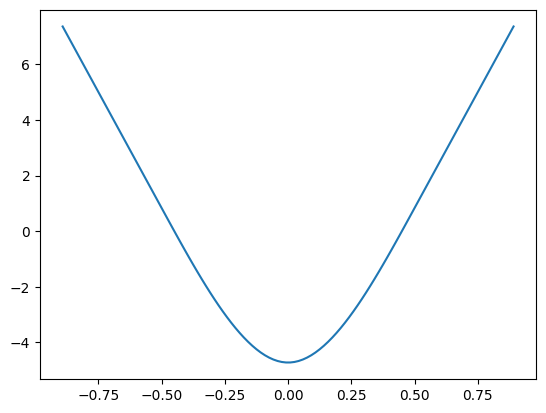

In [64]:


displacement1b_scaled = []

for x in displacement1b:
    displacement1b_scaled.append((x/(E*I))*1000)      #displacement in mm

plt.plot(wing['y_span'], displacement1b_scaled)


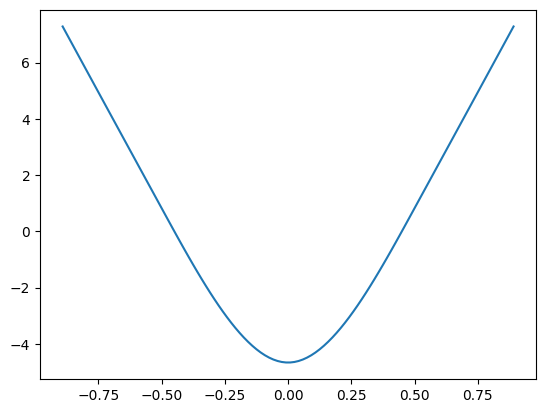

In [65]:
from operator import add
displacement1_scaled = list(map(add, displacement1a_scaled, displacement1b_scaled))

plt.plot(wing['y_span'], displacement1_scaled)

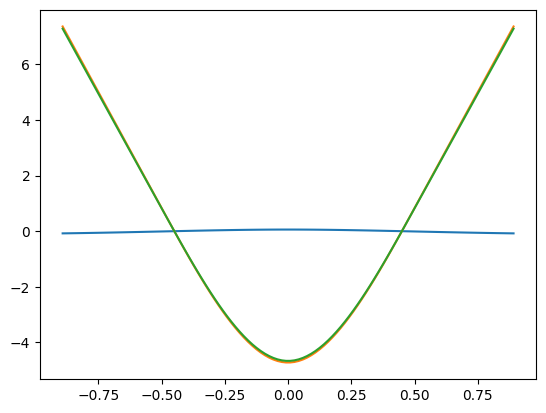

In [66]:
plt.plot(wing['y_span'], displacement1a_scaled)
plt.plot(wing['y_span'], displacement1b_scaled)
plt.plot(wing['y_span'], displacement1_scaled)

In [67]:
d1_max = max(displacement1_scaled) # max displacement of wing spar in mm
d1_max

7.2836916083603915